Epoch: 40, Validation Loss: 0.041583411223255096, Validation Accuracy: 0.986
Epoch: 40, Validation Loss: 0.05172738714143634, Validation Accuracy: 0.983
Epoch: 40, Validation Loss: 0.11730344966053963, Validation Accuracy: 0.962
Epoch: 40, Validation Loss: 2.191911061604818, Validation Accuracy: 0.401
Epoch: 40, Validation Loss: 2.29393994808197, Validation Accuracy: 0.214


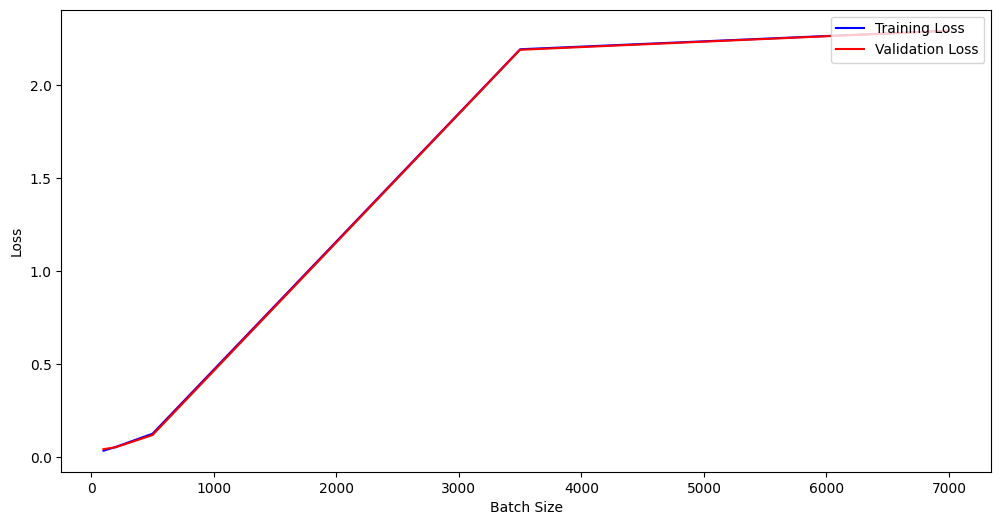

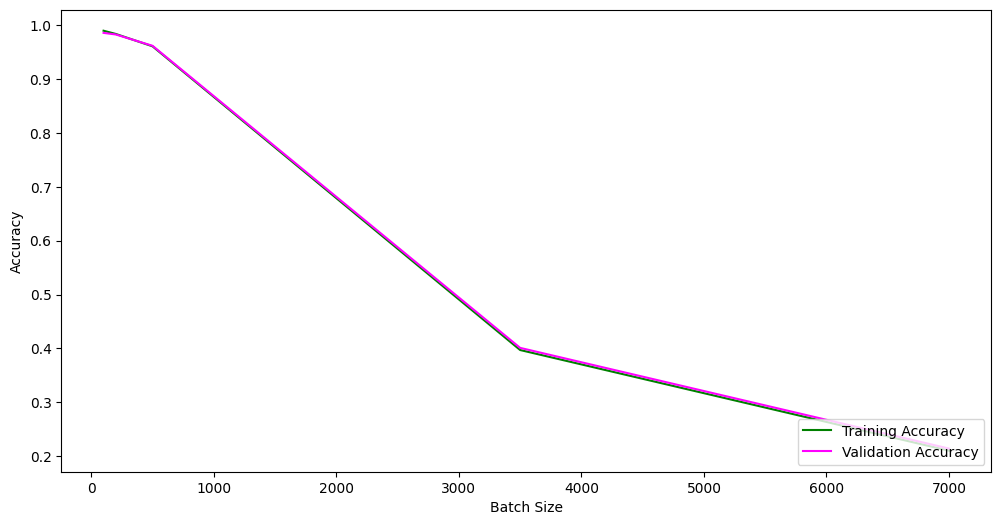

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from PIL import Image
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os


def load_dataset(training_batch_size, validation_batch_size):
    training_dataset = torch.utils.data.DataLoader(
        datasets.MNIST('./dataset', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize((28, 28)),  
                           transforms.ToTensor()
                       ])),
        batch_size=training_batch_size, shuffle=True)

    validation_dataset = torch.utils.data.DataLoader(
        datasets.MNIST('./dataset', train=False, transform=transforms.Compose([
            transforms.Resize((28, 28)), 
            transforms.ToTensor()
        ])),
        batch_size=validation_batch_size, shuffle=True)

    return training_dataset, validation_dataset

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv_layer1 = nn.Conv2d(1, 8, 5)  
        self.conv_layer2 = nn.Conv2d(8, 16, 5)
        self.dense_layer1 = nn.Linear(16 * 4 * 4, 120) 
        self.dense_layer2 = nn.Linear(120, 84)
        self.output_layer = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv_layer1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv_layer2(x)), 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.dense_layer1(x))
        x = F.relu(self.dense_layer2(x))
        x = self.output_layer(x)
        return x

def compute_sensitivity(neural_net):
    total_norm = 0
    parameter_count = 0
    for parameter in neural_net.parameters():
        if parameter.grad is not None:
            gradient_norm = torch.linalg.norm(parameter.grad).item()
            total_norm += gradient_norm
            parameter_count += 1
    return total_norm / parameter_count

def setup_optimizer(neural_net):
    return optim.SGD(neural_net.parameters(), lr=0.01)  

def train_network(neural_net, optimizer, dataset):
    neural_net.train()
    for batch_index, (inputs, targets) in enumerate(dataset):
        inputs, targets = Variable(inputs), Variable(targets)
        optimizer.zero_grad()
        predictions = neural_net(inputs)
        loss_calculator = nn.CrossEntropyLoss()
        loss = loss_calculator(predictions, targets)
        loss.backward()
        optimizer.step()

def evaluate_performance(neural_net, dataset):
    correct = 0
    total = 0
    total_loss = 0
    batch_count = 0
    loss_calculator = nn.CrossEntropyLoss()
    with torch.no_grad():
        for inputs, targets in dataset:
            predictions = neural_net(inputs)
            loss = loss_calculator(predictions, targets)
            total_loss += loss.item()
            batch_count += 1
            _, predicted_labels = torch.max(predictions.data, 1)
            total += targets.size(0)
            correct += (predicted_labels == targets).sum().item()
    average_loss = total_loss / batch_count
    accuracy = correct / total
    return average_loss, round(accuracy, 3)

epochs = 40
batch_sizes = [100, 200, 500, 3500, 7000] 
train_loss_list = []
validation_loss_list = []
train_accuracy_list = []
validation_accuracy_list = []
sensitivity_list = []

def execute_training(neural_net, optimizer, training_dataset, validation_dataset):
    for epoch in range(1, epochs + 1):
        train_network(neural_net, optimizer, training_dataset)
    training_loss, training_accuracy = evaluate_performance(neural_net, training_dataset)
    validation_loss, validation_accuracy = evaluate_performance(neural_net, validation_dataset)

    train_loss_list.append(training_loss)
    validation_loss_list.append(validation_loss)
    train_accuracy_list.append(training_accuracy)
    validation_accuracy_list.append(validation_accuracy)
    print(f'Epoch: {epoch}, Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}')

for batch_size in batch_sizes:
    training_dataset, validation_dataset = load_dataset(batch_size, batch_size)
    neural_net = NeuralNetwork()
    optimizer = setup_optimizer(neural_net)
    execute_training(neural_net, optimizer, training_dataset, validation_dataset)
    sensitivity_list.append(compute_sensitivity(neural_net))

# Plotting results
plt.figure(figsize=(12,6))
plt.plot(batch_sizes, train_loss_list, color="blue") 
plt.plot(batch_sizes, validation_loss_list, color="red") 
plt.xlabel('Batch Size')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

plt.figure(figsize=(12,6))
plt.plot(batch_sizes, train_accuracy_list, color="green")  
plt.plot(batch_sizes, validation_accuracy_list, color="magenta") 
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')

plt.show()
